In [1]:
import pandas as pd
import sys
import os
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from matplotlib.pylab import plt
import seaborn as sns
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from collections import Counter
import re
import string


import nltk  
from wordcloud import WordCloud
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True) 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


In [2]:
df = pd.read_csv('WELFake_Dataset.csv')

In [3]:
df.shape

(72134, 4)

In [4]:
df.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [5]:
df.describe()

,Unnamed: 0,label
count,72134.000000,72134.000000
mean,36066.500000,0.514404
std,20823.436496,0.499796
min,0.000000,0.000000
25%,18033.250000,0.000000
50%,36066.500000,1.000000
75%,54099.750000,1.000000
max,72133.000000,1.000000


In [6]:
df.isnull().sum()

Unnamed: 0      0
title         558
text           39
label           0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72134 non-null  int64 
 1   title       71576 non-null  object
 2   text        72095 non-null  object
 3   label       72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB


In [8]:
y = df.label
y.value_counts(normalize=True).rename({1: 'real', 0: 'fake'})

label
real    0.514404
fake    0.485596
Name: proportion, dtype: float64

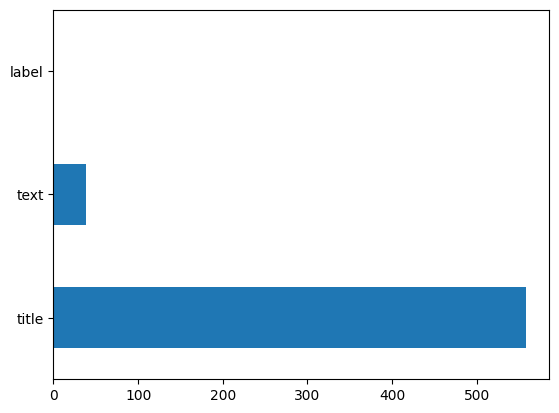

In [9]:
df.drop(["Unnamed: 0"], axis=1, inplace=True)
df.isnull().sum().plot(kind="barh")
plt.show()

In [10]:
df = df.fillna('')

In [11]:
df.isnull().sum()

title    0
text     0
label    0
dtype: int64

In [12]:
df.nunique()

title    62348
text     62719
label        2
dtype: int64

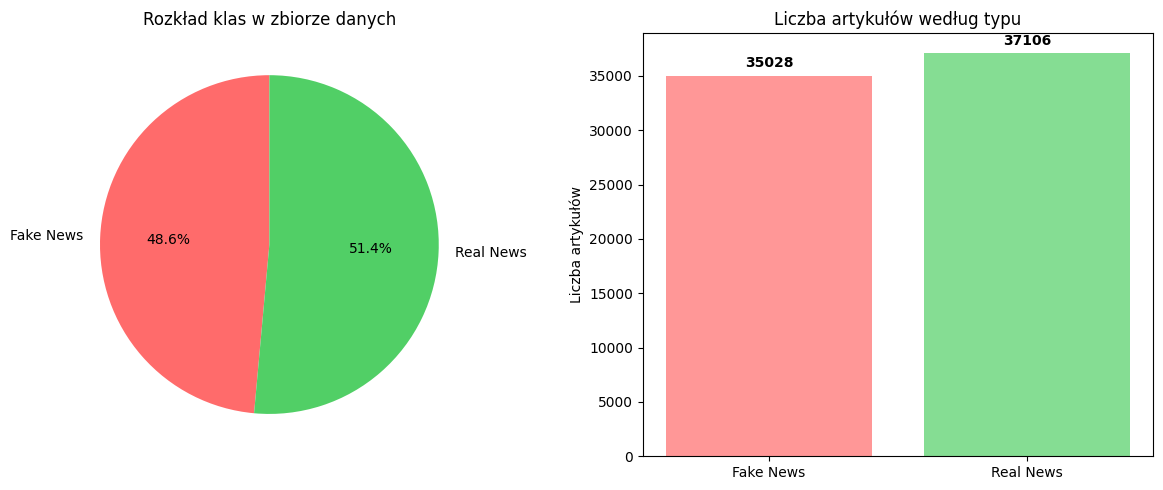

In [13]:
# Analiza rozkładu klas
plt.figure(figsize=(12, 5))

#ozkład klas
plt.subplot(1, 2, 1)
labels = ['Fake News', 'Real News']
counts = df['label'].value_counts().sort_index()
colors = ['#ff6b6b', '#51cf66']
plt.pie(counts, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title('Rozkład klas w zbiorze danych')

plt.subplot(1, 2, 2)
bars = plt.bar(labels, counts, color=colors, alpha=0.7)
plt.title('Liczba artykułów według typu')
plt.ylabel('Liczba artykułów')
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 500, 
             str(count), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


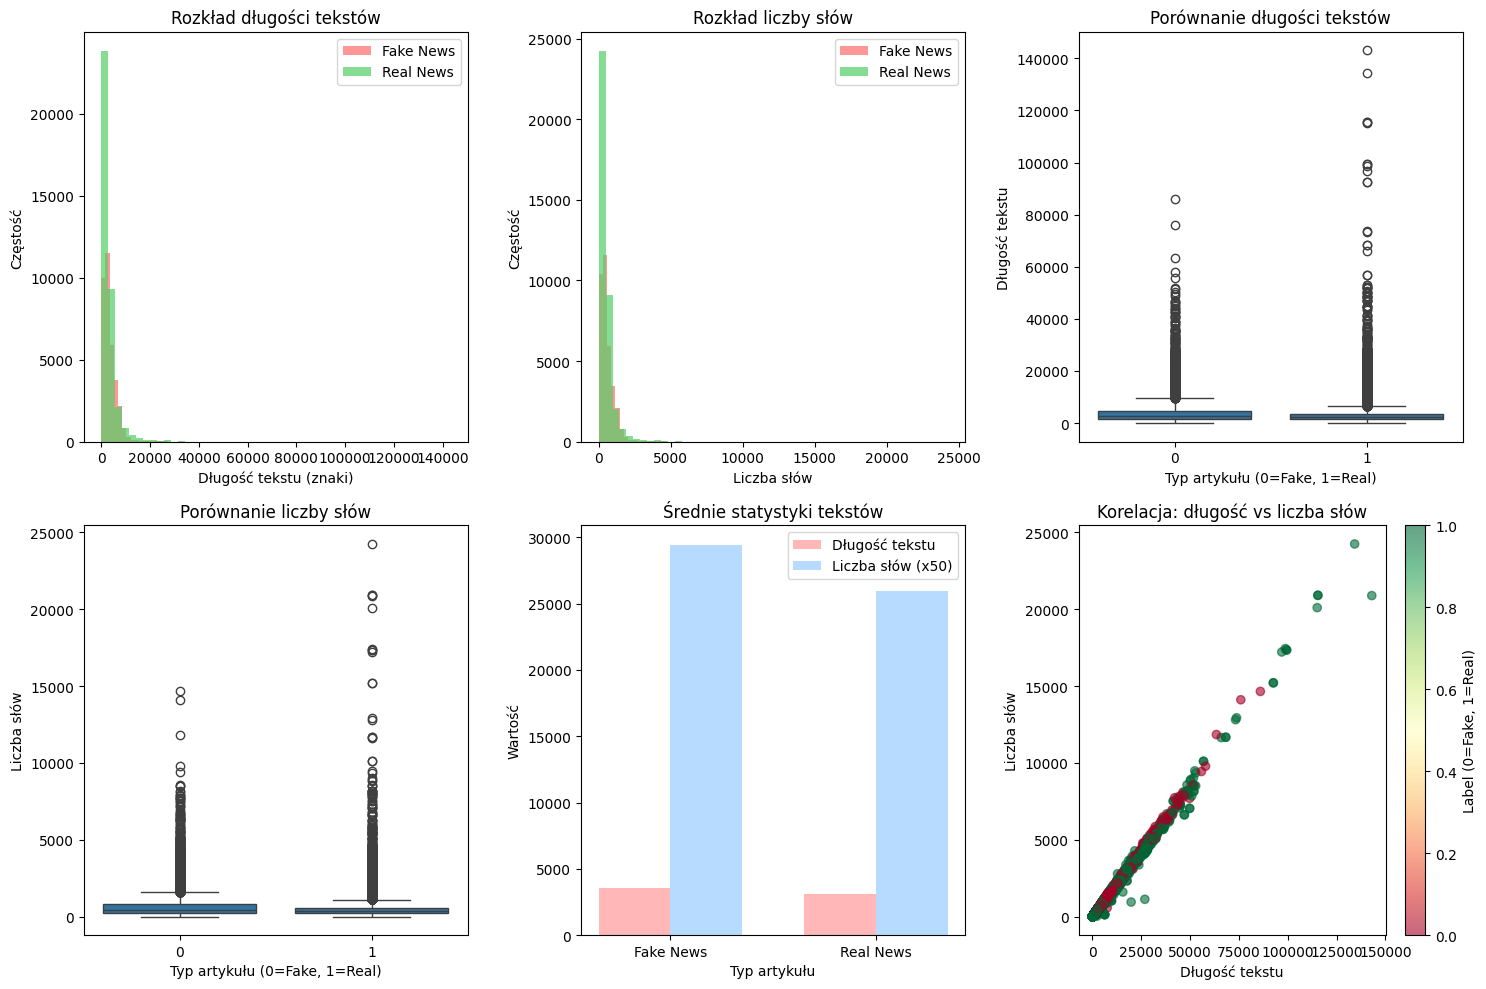

In [14]:
# Analiza długości tekstów
df['combined_text'] = df['title'].fillna('') + ' ' + df['text'].fillna('')
df['text_length'] = df['combined_text'].str.len()
df['word_count'] = df['combined_text'].str.split().str.len()

plt.figure(figsize=(15, 10))

# Wykres Rozkład długości tekstów
plt.subplot(2, 3, 1)
plt.hist(df[df['label']==0]['text_length'], bins=50, alpha=0.7, label='Fake News', color='#ff6b6b')
plt.hist(df[df['label']==1]['text_length'], bins=50, alpha=0.7, label='Real News', color='#51cf66')
plt.xlabel('Długość tekstu (znaki)')
plt.ylabel('Częstość')
plt.title('Rozkład długości tekstów')
plt.legend()

# Wykres Rozkład liczby słów
plt.subplot(2, 3, 2)
plt.hist(df[df['label']==0]['word_count'], bins=50, alpha=0.7, label='Fake News', color='#ff6b6b')
plt.hist(df[df['label']==1]['word_count'], bins=50, alpha=0.7, label='Real News', color='#51cf66')
plt.xlabel('Liczba słów')
plt.ylabel('Częstość')
plt.title('Rozkład liczby słów')
plt.legend()

# Wykres Boxplot długości tekstów
plt.subplot(2, 3, 3)
sns.boxplot(data=df, x='label', y='text_length')
plt.xlabel('Typ artykułu (0=Fake, 1=Real)')
plt.ylabel('Długość tekstu')
plt.title('Porównanie długości tekstów')

# Wykres Boxplot liczby słów
plt.subplot(2, 3, 4)
sns.boxplot(data=df, x='label', y='word_count')
plt.xlabel('Typ artykułu (0=Fake, 1=Real)')
plt.ylabel('Liczba słów')
plt.title('Porównanie liczby słów')

# Wykres Średnie wartości
plt.subplot(2, 3, 5)
stats_by_label = df.groupby('label')[['text_length', 'word_count']].mean()
x = ['Fake News', 'Real News']
width = 0.35
x_pos = np.arange(len(x))

bars1 = plt.bar(x_pos - width/2, stats_by_label['text_length'], width, 
                label='Długość tekstu', alpha=0.7, color='#ff9999')
bars2 = plt.bar(x_pos + width/2, stats_by_label['word_count']*50, width, 
                label='Liczba słów (x50)', alpha=0.7, color='#99ccff')

plt.xlabel('Typ artykułu')
plt.ylabel('Wartość')
plt.title('Średnie statystyki tekstów')
plt.xticks(x_pos, x)
plt.legend()

# Wykres Korelacja
plt.subplot(2, 3, 6)
plt.scatter(df['text_length'], df['word_count'], 
           c=df['label'], cmap='RdYlGn', alpha=0.6)
plt.xlabel('Długość tekstu')
plt.ylabel('Liczba słów')
plt.title('Korelacja: długość vs liczba słów')
plt.colorbar(label='Label (0=Fake, 1=Real)')

plt.tight_layout()
plt.show()

In [15]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    """Funkcja do czyszczenia tekstu"""
    if pd.isna(text):
        return ""
    
    # Konwersja na małe litery
    text = text.lower()
    
    # Usunięcie znaków interpunkcyjnych i cyfr
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenizacja
    tokens = word_tokenize(text)
    
    # Usunięcie stopwords i krótkich słów
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    
    return ' '.join(tokens)

# Czyszczenie tekstów
df['cleaned_text'] = df['combined_text'].apply(clean_text)

# Analiza najczęstszych słów
def get_top_words(texts, n=20):
    """Zwraca najczęstsze słowa"""
    all_words = ' '.join(texts).split()
    return Counter(all_words).most_common(n)

fake_news_texts = df[df['label'] == 0]['cleaned_text'].tolist()
real_news_texts = df[df['label'] == 1]['cleaned_text'].tolist()

fake_top_words = get_top_words(fake_news_texts)
real_top_words = get_top_words(real_news_texts)

print("Top 10 słów w Fake News:")
for word, count in fake_top_words[:10]:
    print(f"{word}: {count}")

print("\nTop 10 słów w Real News:")
for word, count in real_top_words[:10]:
    print(f"{word}: {count}")

print(f"\nPrzetworzono {len(df)} artykułów.")

Top 10 słów w Fake News:
said: 184625
trump: 90825
would: 62656
new: 50062
president: 47858
one: 41813
people: 41194
also: 36626
state: 35995
states: 34132

Top 10 słów w Real News:
trump: 105530
people: 47822
said: 47143
one: 43892
would: 43146
clinton: 41854
president: 37012
hillary: 32280
like: 31420
new: 29474

Przetworzono 72134 artykułów.


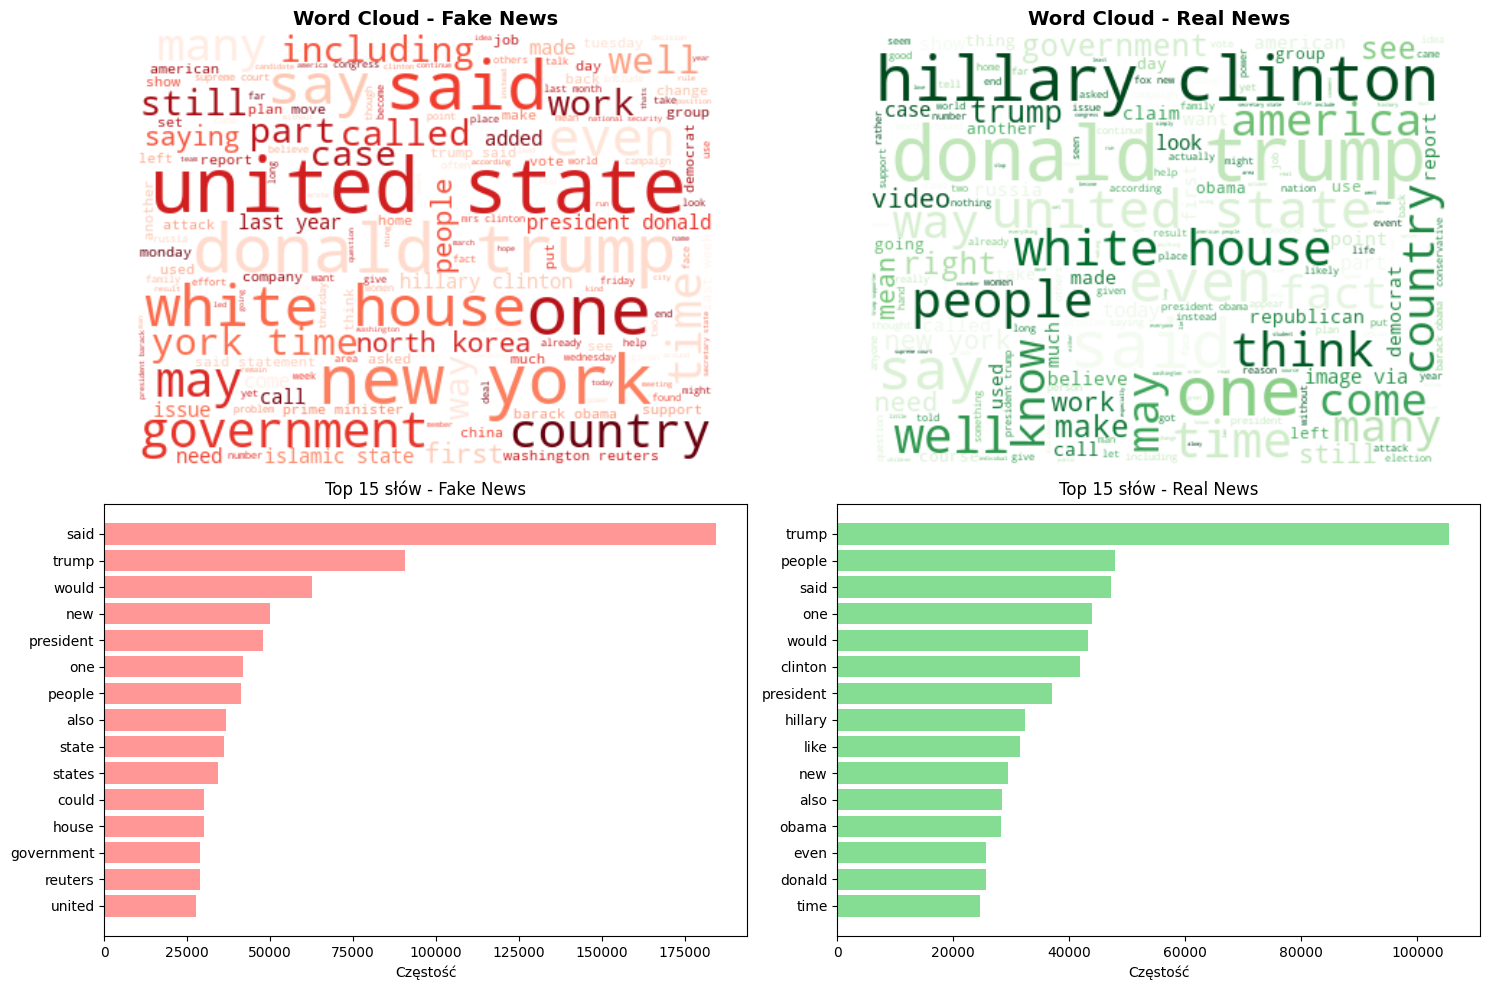

Wspólne słowa (top 100): 12
Unikalne słowa Fake News: 8
Unikalne słowa Real News: 8

Najczęstsze unikalne słowa Fake News: ['reuters', 'united', 'republican', 'states', 'government', 'house', 'two', 'last']
Najczęstsze unikalne słowa Real News: ['many', 'media', 'time', 'even', 'news', 'obama', 'hillary', 'donald']


In [16]:
# Wizualizacja najczęstszych słów
plt.figure(figsize=(15, 10))

# WordCloud dla Fake News
plt.subplot(2, 2, 1)
fake_text = ' '.join(fake_news_texts)
if fake_text.strip():
    wordcloud_fake = WordCloud(width=400, height=300, background_color='white', 
                              colormap='Reds').generate(fake_text)
    plt.imshow(wordcloud_fake, interpolation='bilinear')
    plt.title('Word Cloud - Fake News', fontsize=14, fontweight='bold')
    plt.axis('off')

# WordCloud dla Real News
plt.subplot(2, 2, 2)
real_text = ' '.join(real_news_texts)
if real_text.strip():
    wordcloud_real = WordCloud(width=400, height=300, background_color='white', 
                              colormap='Greens').generate(real_text)
    plt.imshow(wordcloud_real, interpolation='bilinear')
    plt.title('Word Cloud - Real News', fontsize=14, fontweight='bold')
    plt.axis('off')

# Top słowa Fake News
plt.subplot(2, 2, 3)
fake_words, fake_counts = zip(*fake_top_words[:15])
plt.barh(fake_words[::-1], fake_counts[::-1], color='#ff6b6b', alpha=0.7)
plt.title('Top 15 słów - Fake News')
plt.xlabel('Częstość')

# Top słowa Real News
plt.subplot(2, 2, 4)
real_words, real_counts = zip(*real_top_words[:15])
plt.barh(real_words[::-1], real_counts[::-1], color='#51cf66', alpha=0.7)
plt.title('Top 15 słów - Real News')
plt.xlabel('Częstość')

plt.tight_layout()
plt.show()

# Analiza unikalnych słów
fake_words_set = set([word for word, _ in fake_top_words[:100]])
real_words_set = set([word for word, _ in real_top_words[:100]])

common_words = fake_words_set.intersection(real_words_set)
fake_unique = fake_words_set - real_words_set
real_unique = real_words_set - fake_words_set

print(f"Wspólne słowa (top 100): {len(common_words)}")
print(f"Unikalne słowa Fake News: {len(fake_unique)}")
print(f"Unikalne słowa Real News: {len(real_unique)}")

print(f"\nNajczęstsze unikalne słowa Fake News: {list(fake_unique)[:10]}")
print(f"Najczęstsze unikalne słowa Real News: {list(real_unique)[:10]}")

In [17]:
# Usunięcie wierszy z pustymi tekstami
df_clean = df[df['cleaned_text'].str.len() > 10].copy()
print(f"Liczba artykułów po czyszczeniu: {len(df_clean)}")

# Podział danych
X = df_clean['cleaned_text']
y = df_clean['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Zbiór treningowy: {len(X_train)}")
print(f"Zbiór testowy: {len(X_test)}")
print(f"Rozkład klas w zbiorze treningowym:")
print(y_train.value_counts(normalize=True))
print(f"Rozkład klas w zbiorze testowym:")
print(y_test.value_counts(normalize=True))

Liczba artykułów po czyszczeniu: 72033
Zbiór treningowy: 57626
Zbiór testowy: 14407
Rozkład klas w zbiorze treningowym:
label
1    0.513726
0    0.486274
Name: proportion, dtype: float64
Rozkład klas w zbiorze testowym:
label
1    0.513709
0    0.486291
Name: proportion, dtype: float64


In [18]:
#Modele
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Naive Bayes': MultinomialNB(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
}

# Trenowanie i ewaluacja modeli
results = {}
trained_models = {}

print("Trenowanie modeli...")
print("="*50)

for name, model in models.items():
    print(f"\nTrenowanie {name}...")
    
    # Pipeline z TF-IDF i modelem
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=10000, stop_words='english', ngram_range=(1, 2))),
        ('classifier', model)
    ])
    
    # Trenowanie
    pipeline.fit(X_train, y_train)
    
    # Predykcje
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1] if hasattr(pipeline, 'predict_proba') else None
    
    # Metryki
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    if y_pred_proba is not None:
        auc = roc_auc_score(y_test, y_pred_proba)
    else:
        auc = None
    
    results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    trained_models[name] = pipeline
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    if auc:
        print(f"AUC: {auc:.4f}")


Trenowanie modeli...

Trenowanie Logistic Regression...


/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:209: RuntimeWarning: divide by zero encountered in matmul
  norm2_w = weights @ weights if weights.ndim == 1 else squared_norm(weights)
/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:209: RuntimeWarning: overflow encountered in matmul
  norm2_w = weights @ weights if weights.ndim == 1 else squared_norm(weights)
/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:209: RuntimeWarning: invalid value encountered in matmul
  norm2_w = weights @ weights if weights.ndim == 1 else squared_norm(weights)


Accuracy: 0.9531
Precision: 0.9486
Recall: 0.9608
F1-score: 0.9547
AUC: 0.9896

Trenowanie Naive Bayes...
Accuracy: 0.8565
Precision: 0.8401
Recall: 0.8901
F1-score: 0.8644
AUC: 0.9320

Trenowanie Random Forest...
Accuracy: 0.9601
Precision: 0.9518
Recall: 0.9715
F1-score: 0.9616
AUC: 0.9938


Porównanie wyników modeli:
                     accuracy  precision  recall      f1     auc
Logistic Regression    0.9531     0.9486  0.9608  0.9547  0.9896
Naive Bayes            0.8565     0.8401  0.8901  0.8644  0.9320
Random Forest          0.9601     0.9518  0.9715  0.9616  0.9938


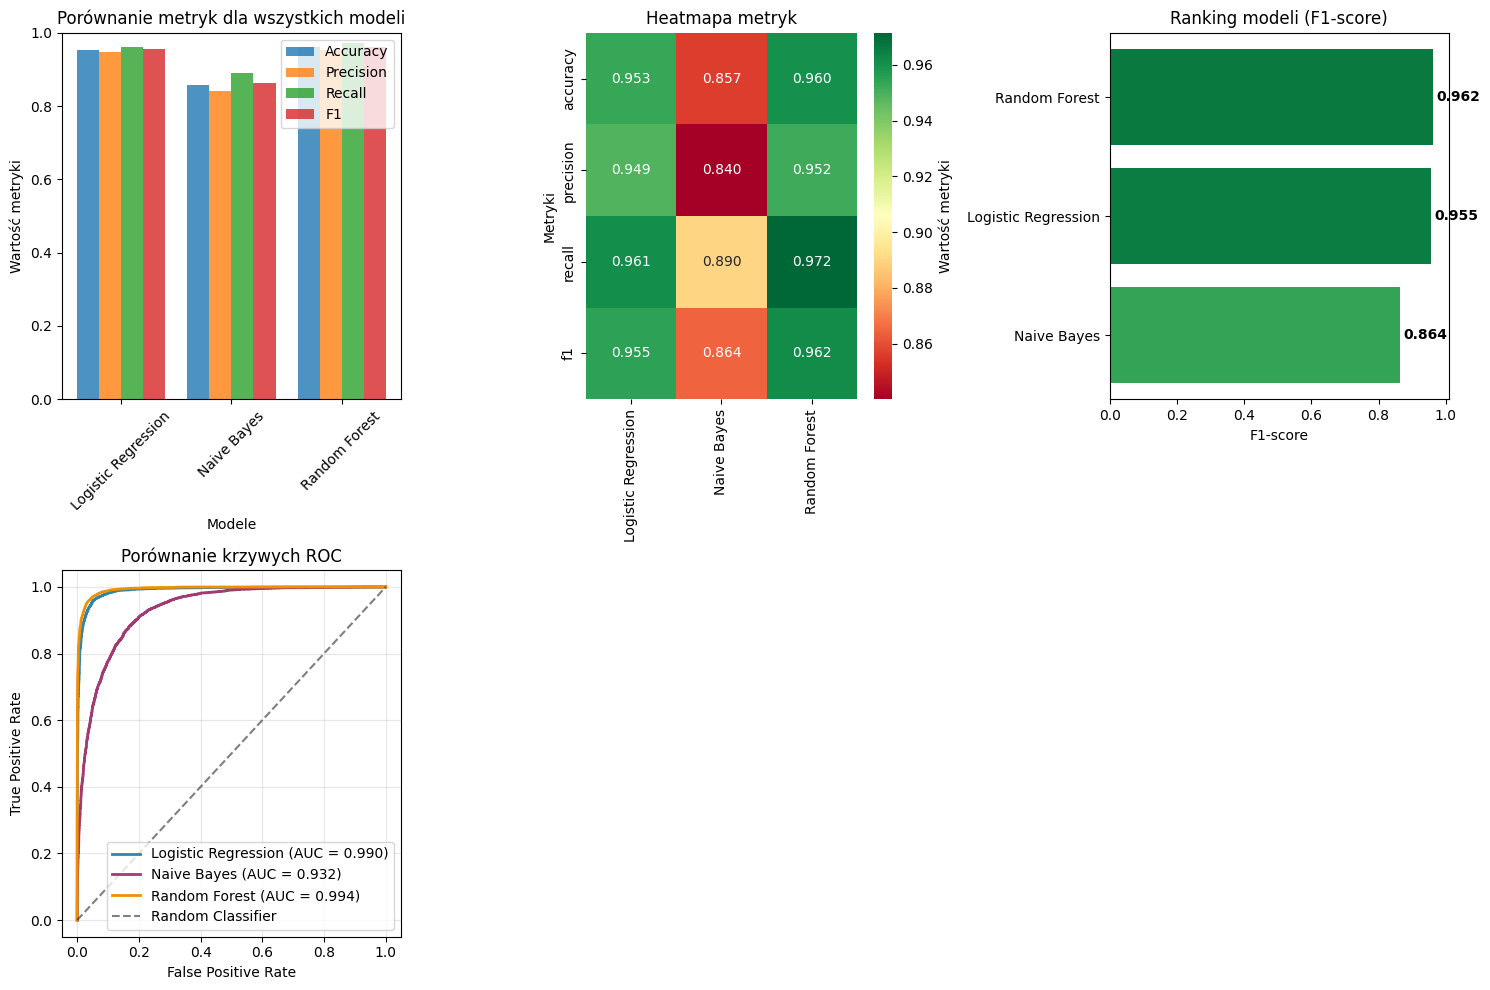


Najlepszy model: Random Forest


In [19]:
# Porównanie wyników modeli
results_df = pd.DataFrame(results).T
results_df = results_df.drop(['y_pred', 'y_pred_proba'], axis=1)
for col in ['accuracy', 'precision', 'recall', 'f1', 'auc']:
    results_df[col] = pd.to_numeric(results_df[col], errors='coerce')

results_df = results_df.round(4)

print("Porównanie wyników modeli:")
print("="*60)
print(results_df.to_string())

# Wizualizacja wyników
plt.figure(figsize=(15, 10))

# Wykres Metryk
plt.subplot(2, 3, 1)
metrics = ['accuracy', 'precision', 'recall', 'f1']
x = np.arange(len(results_df.index))
width = 0.2

for i, metric in enumerate(metrics):
    values = results_df[metric].values
    plt.bar(x + i*width, values, width, label=metric.capitalize(), alpha=0.8)

plt.xlabel('Modele')
plt.ylabel('Wartość metryki')
plt.title('Porównanie metryk dla wszystkich modeli')
plt.xticks(x + width*1.5, results_df.index, rotation=45)
plt.legend()
plt.ylim(0, 1)

#Heatmapa metryk 
plt.subplot(2, 3, 2)
metrics_for_heatmap = results_df[['accuracy', 'precision', 'recall', 'f1']].fillna(0)
sns.heatmap(metrics_for_heatmap.T, annot=True, cmap='RdYlGn', 
            fmt='.3f', cbar_kws={'label': 'Wartość metryki'})
plt.title('Heatmapa metryk')
plt.ylabel('Metryki')

#Ranking modeli według F1
plt.subplot(2, 3, 3)
f1_sorted = results_df.sort_values('f1', ascending=True)
colors = plt.cm.RdYlGn(f1_sorted['f1'])
bars = plt.barh(range(len(f1_sorted)), f1_sorted['f1'], color=colors)
plt.yticks(range(len(f1_sorted)), f1_sorted.index)
plt.xlabel('F1-score')
plt.title('Ranking modeli (F1-score)')
for i, (idx, row) in enumerate(f1_sorted.iterrows()):
    plt.text(row['f1'] + 0.01, i, f'{row["f1"]:.3f}', 
             va='center', fontweight='bold')

#Krzywe ROC
plt.subplot(2, 3, 4)
colors = ['#2E86AB', '#A23B72', '#F18F01']
for i, (name, result) in enumerate(results.items()):
    if result['y_pred_proba'] is not None:
        fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
        auc_score = roc_auc_score(y_test, result['y_pred_proba'])
        plt.plot(fpr, tpr, linewidth=2, color=colors[i % len(colors)], 
                label=f'{name} (AUC = {auc_score:.3f})')

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Porównanie krzywych ROC')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#najlepszy model
best_model_name = results_df['f1'].idxmax()
print(f"\nNajlepszy model: {best_model_name}")


Szczegółowa analiza modelu: Random Forest


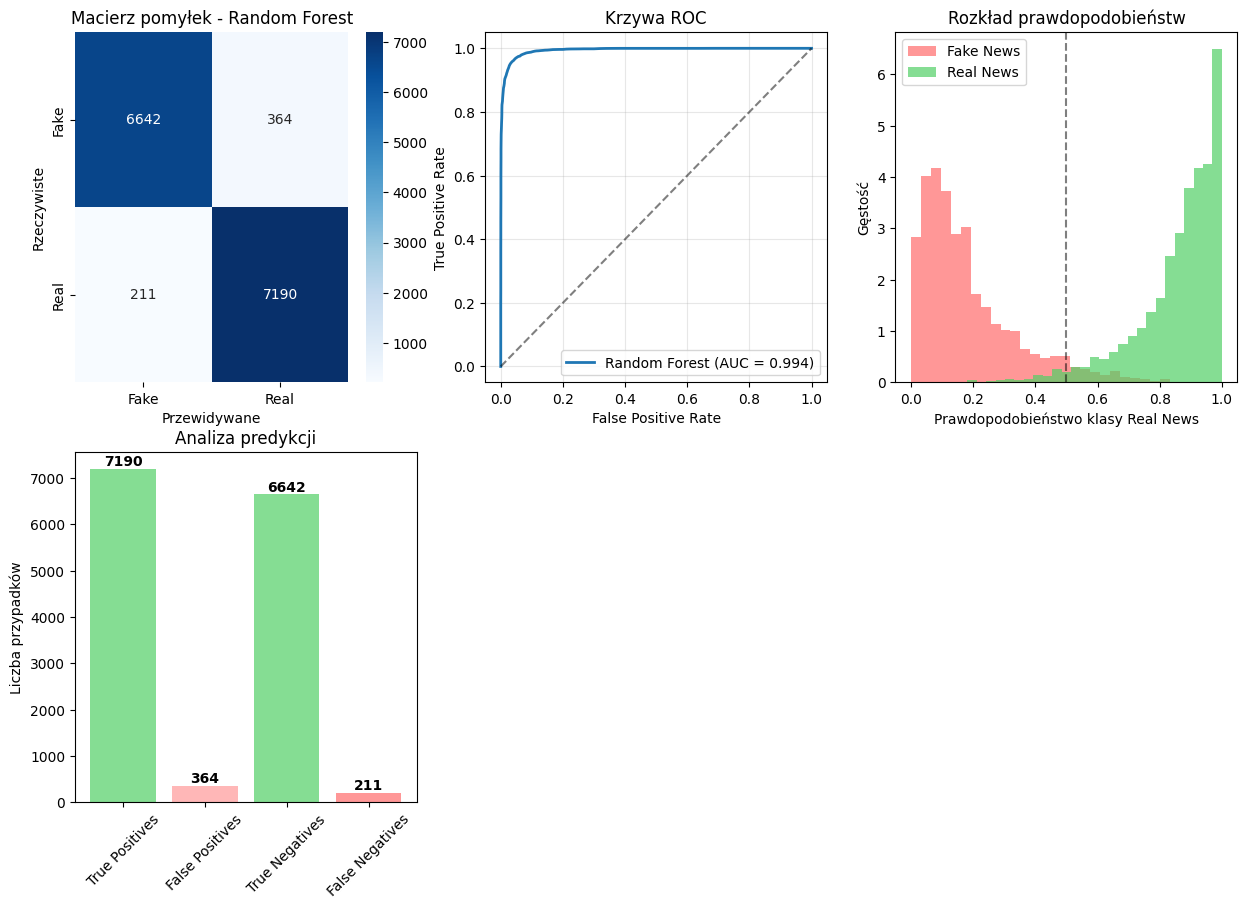

In [20]:
# Szczegółowa analiza najlepszego modelu
best_model_name = results_df['f1'].idxmax()
best_pipeline = trained_models[best_model_name]
best_results = results[best_model_name]

print(f"Szczegółowa analiza modelu: {best_model_name}")


# Wizualizacja wyników najlepszego modelu
plt.figure(figsize=(15, 10))

# Macierz pomyłek
plt.subplot(2, 3, 1)
cm = confusion_matrix(y_test, best_results['y_pred'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title(f'Macierz pomyłek - {best_model_name}')
plt.ylabel('Rzeczywiste')
plt.xlabel('Przewidywane')

# Krzywa ROC
if best_results['y_pred_proba'] is not None:
    plt.subplot(2, 3, 2)
    fpr, tpr, _ = roc_curve(y_test, best_results['y_pred_proba'])
    auc_score = roc_auc_score(y_test, best_results['y_pred_proba'])
    plt.plot(fpr, tpr, linewidth=2, label=f'{best_model_name} (AUC = {auc_score:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Krzywa ROC')
    plt.legend()
    plt.grid(True, alpha=0.3)

# Rozkład prawdopodobieństw
if best_results['y_pred_proba'] is not None:
    plt.subplot(2, 3, 3)
    fake_probs = best_results['y_pred_proba'][y_test == 0]
    real_probs = best_results['y_pred_proba'][y_test == 1]
    
    plt.hist(fake_probs, bins=30, alpha=0.7, label='Fake News', color='#ff6b6b', density=True)
    plt.hist(real_probs, bins=30, alpha=0.7, label='Real News', color='#51cf66', density=True)
    plt.xlabel('Prawdopodobieństwo klasy Real News')
    plt.ylabel('Gęstość')
    plt.title('Rozkład prawdopodobieństw')
    plt.legend()
    plt.axvline(x=0.5, color='black', linestyle='--', alpha=0.5)

# Analiza błędnych predykcji
plt.subplot(2, 3, 4)
correct = (y_test == best_results['y_pred'])
error_types = ['True Positives', 'False Positives', 'True Negatives', 'False Negatives']
error_counts = [
    np.sum((y_test == 1) & (best_results['y_pred'] == 1)),  # TP
    np.sum((y_test == 0) & (best_results['y_pred'] == 1)),  # FP
    np.sum((y_test == 0) & (best_results['y_pred'] == 0)),  # TN
    np.sum((y_test == 1) & (best_results['y_pred'] == 0))   # FN
]
colors = ['#51cf66', '#ff9999', '#51cf66', '#ff6b6b']
bars = plt.bar(error_types, error_counts, color=colors, alpha=0.7)
plt.title('Analiza predykcji')
plt.ylabel('Liczba przypadków')
plt.xticks(rotation=45)
for bar, count in zip(bars, error_counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
             str(count), ha='center', va='bottom', fontweight='bold')



Analiza najważniejszych cech w modelu: Random Forest


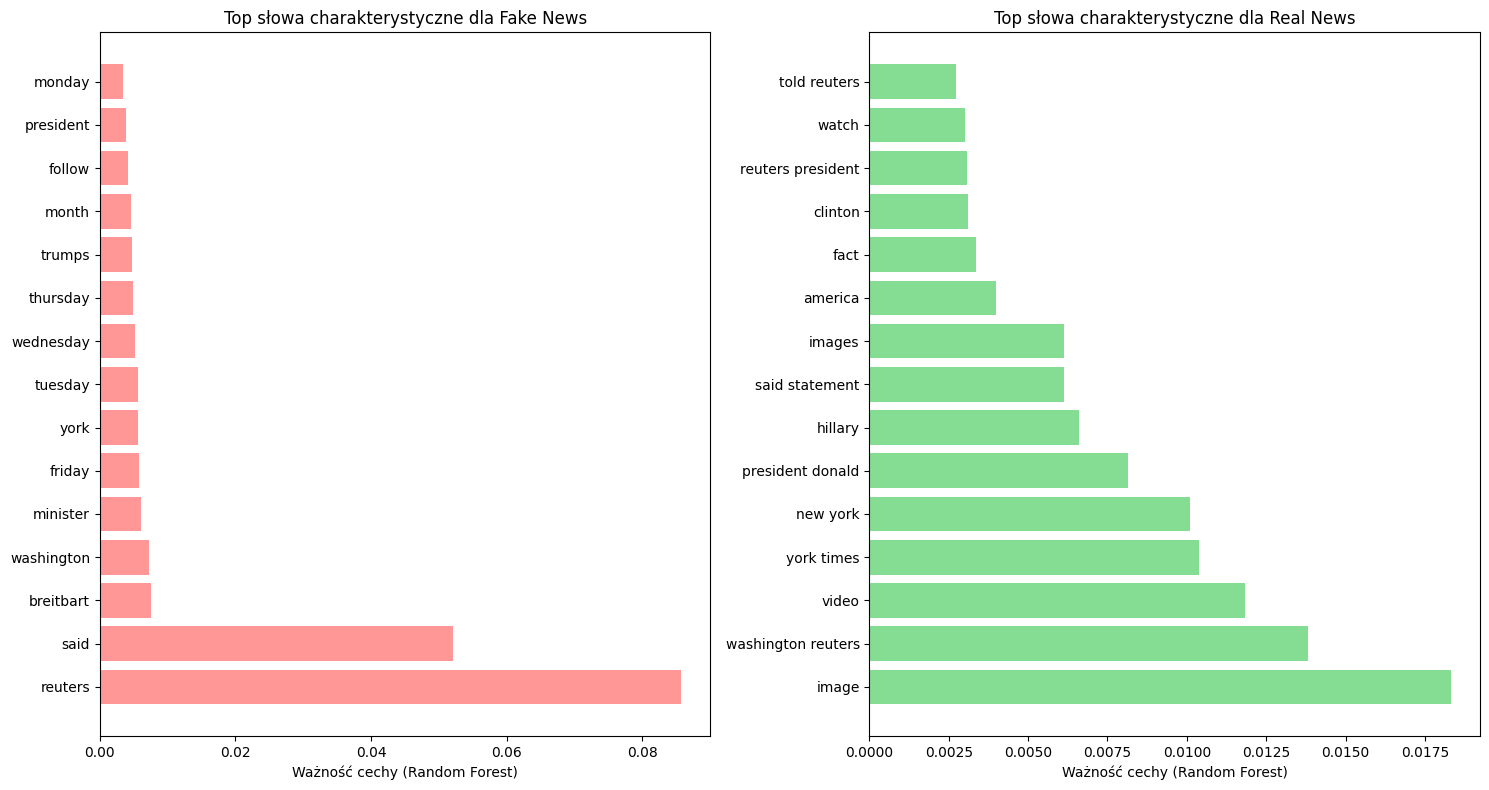

In [21]:
# Analiza cech ważnych w modelu
if best_model_name in ['Random Forest']:
    print(f"Analiza najważniejszych cech w modelu: {best_model_name}")
    
    # Pobranie nazw cech (słów)
    feature_names = best_pipeline.named_steps['tfidf'].get_feature_names_out()
        
    if best_model_name == 'Random Forest':
        importances = best_pipeline.named_steps['classifier'].feature_importances_       
        # Top najważniejsze cechy
        top_indices = np.argsort(importances)[-40:]
        top_features = [(feature_names[i], importances[i]) for i in top_indices]
        
        # Analiza częstości słów w każdej klasie
        fake_texts = ' '.join(df_clean[df_clean['label'] == 0]['cleaned_text'])
        real_texts = ' '.join(df_clean[df_clean['label'] == 1]['cleaned_text'])
        
        fake_words_freq = Counter(fake_texts.split())
        real_words_freq = Counter(real_texts.split())
        
        # Podział słów na podstawie częstości w klasach
        fake_words = []
        real_words = []
        
        for word, importance in top_features:
            fake_count = fake_words_freq.get(word, 0)
            real_count = real_words_freq.get(word, 0)
            
            # Słowo charakterystyczne dla danej klasy jeśli występuje częściej w tej klasie
            if fake_count > real_count:
                fake_words.append((word, importance))
            else:
                real_words.append((word, importance))
    
    plt.figure(figsize=(15, 8))
    
    # Słowa charakterystyczne dla Fake News
    plt.subplot(1, 2, 1)
    if fake_words:
        words, values = zip(*fake_words[-15:])
        plt.barh(range(len(words)), [abs(v) for v in values], color='#ff6b6b', alpha=0.7)
        plt.yticks(range(len(words)), words)
        plt.xlabel('Ważność cechy (Random Forest)')
        plt.title('Top słowa charakterystyczne dla Fake News')
        plt.gca().invert_yaxis()
    
    # Słowa charakterystyczne dla Real News
    plt.subplot(1, 2, 2)
    if real_words:
        words, values = zip(*real_words[-15:])
        plt.barh(range(len(words)), [abs(v) for v in values], color='#51cf66', alpha=0.7)
        plt.yticks(range(len(words)), words)
        plt.xlabel('Ważność cechy (Random Forest)')
        plt.title('Top słowa charakterystyczne dla Real News')
        plt.gca().invert_yaxis()
    
    plt.tight_layout()
    plt.show()


In [22]:
# Podsumowanie i wnioski

print(f"\nSTATYSTYKI ZBIORU DANYCH:")
print(f"   • Całkowita liczba artykułów: {len(df):,}")
print(f"   • Artykuły po czyszczeniu: {len(df_clean):,}")
print(f"   • Fake News: {len(df_clean[df_clean['label']==0]):,} ({len(df_clean[df_clean['label']==0])/len(df_clean)*100:.1f}%)")
print(f"   • Real News: {len(df_clean[df_clean['label']==1]):,} ({len(df_clean[df_clean['label']==1])/len(df_clean)*100:.1f}%)")

print(f"\nTESTOWANE MODELE:")
for model_name in models.keys():
    print(f"   • {model_name}")

print(f"\nNAJLEPSZY MODEL: {best_model_name}")
print(f"   • Accuracy: {results_df.loc[best_model_name, 'accuracy']:.4f}")
print(f"   • Precision: {results_df.loc[best_model_name, 'precision']:.4f}")
print(f"   • Recall: {results_df.loc[best_model_name, 'recall']:.4f}")
print(f"   • F1-score: {results_df.loc[best_model_name, 'f1']:.4f}")
if results_df.loc[best_model_name, 'auc'] is not None:
    print(f"   • AUC: {results_df.loc[best_model_name, 'auc']:.4f}")




STATYSTYKI ZBIORU DANYCH:
   • Całkowita liczba artykułów: 72,134
   • Artykuły po czyszczeniu: 72,033
   • Fake News: 35,028 (48.6%)
   • Real News: 37,005 (51.4%)

TESTOWANE MODELE:
   • Logistic Regression
   • Naive Bayes
   • Random Forest

NAJLEPSZY MODEL: Random Forest
   • Accuracy: 0.9601
   • Precision: 0.9518
   • Recall: 0.9715
   • F1-score: 0.9616
   • AUC: 0.9938
